Trains a grammar encoder to predict meta-scene-tree production params (grammars) on the 2D box grammar.

In [1]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks.grammar import *

Unconditional grammar outputs look like this:

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


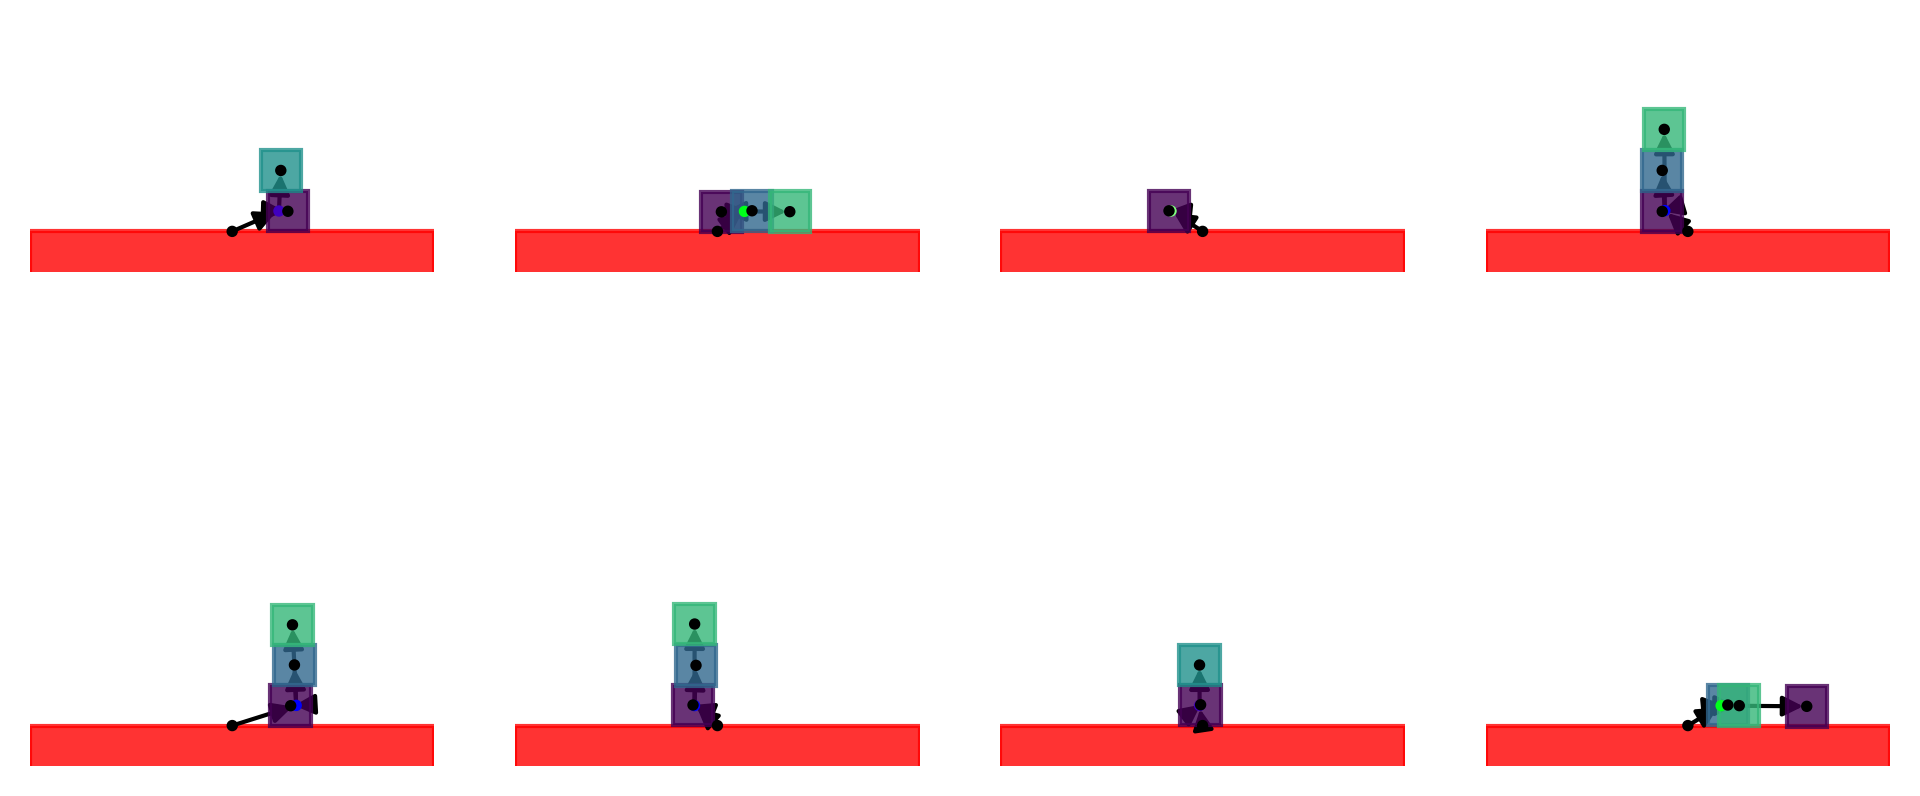

In [2]:
root_inst_dict = {"xy": dist.Normal(torch.tensor([0., 0.]), torch.tensor([0.001, 0.001]))}
grammar = SceneGrammar(Ground, root_inst_dict)
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = grammar()
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

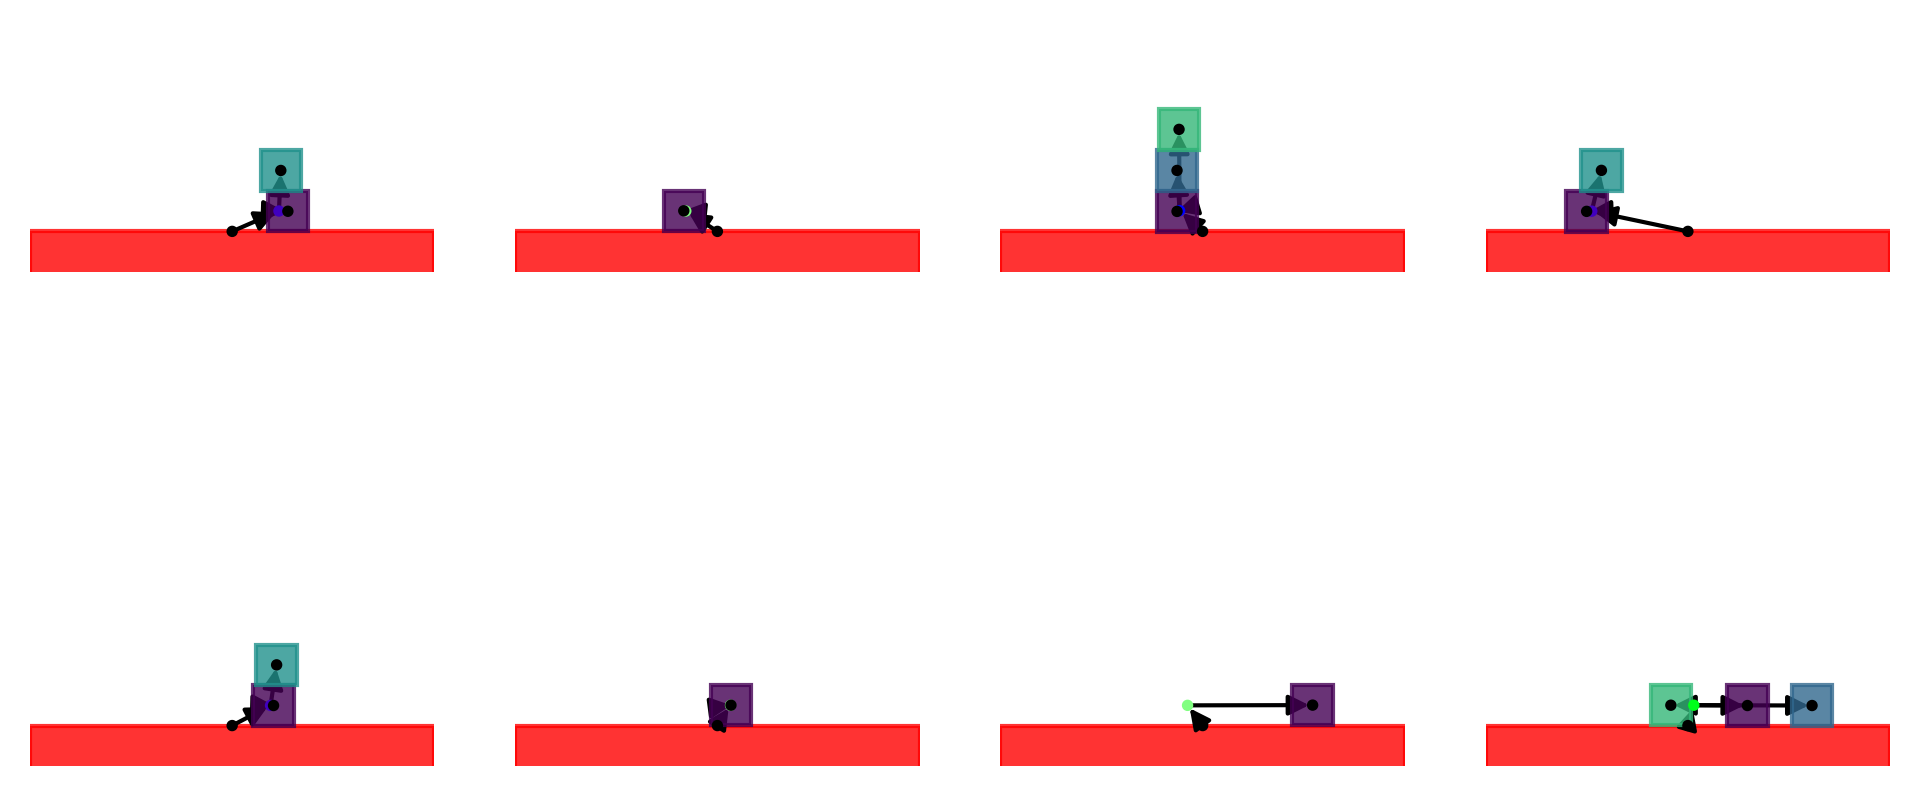

In [3]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
observed_full_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_full_trees.append(scene_trees[0])
plt.show()

In [4]:
trace = pyro.poutine.trace(grammar.forward).get_trace()
print(trace.nodes.keys())

odict_keys(['_INPUT', 'Ground_25_sample_derived/xy', 'Ground_25_choose_children/sample_children_inclusion', 'GroupOf2_2_sample_derived/xy', 'GroupOf2_2_choose_children/sample_children_inclusion', 'Box_56_sample_derived/xy', 'Box_57_sample_derived/xy', '_RETURN'])


The "meta" ("super"? "Hyper", as in hypergraph? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


(327.28485000000006, 712.58515, -16.899900000000002, 385.2799)

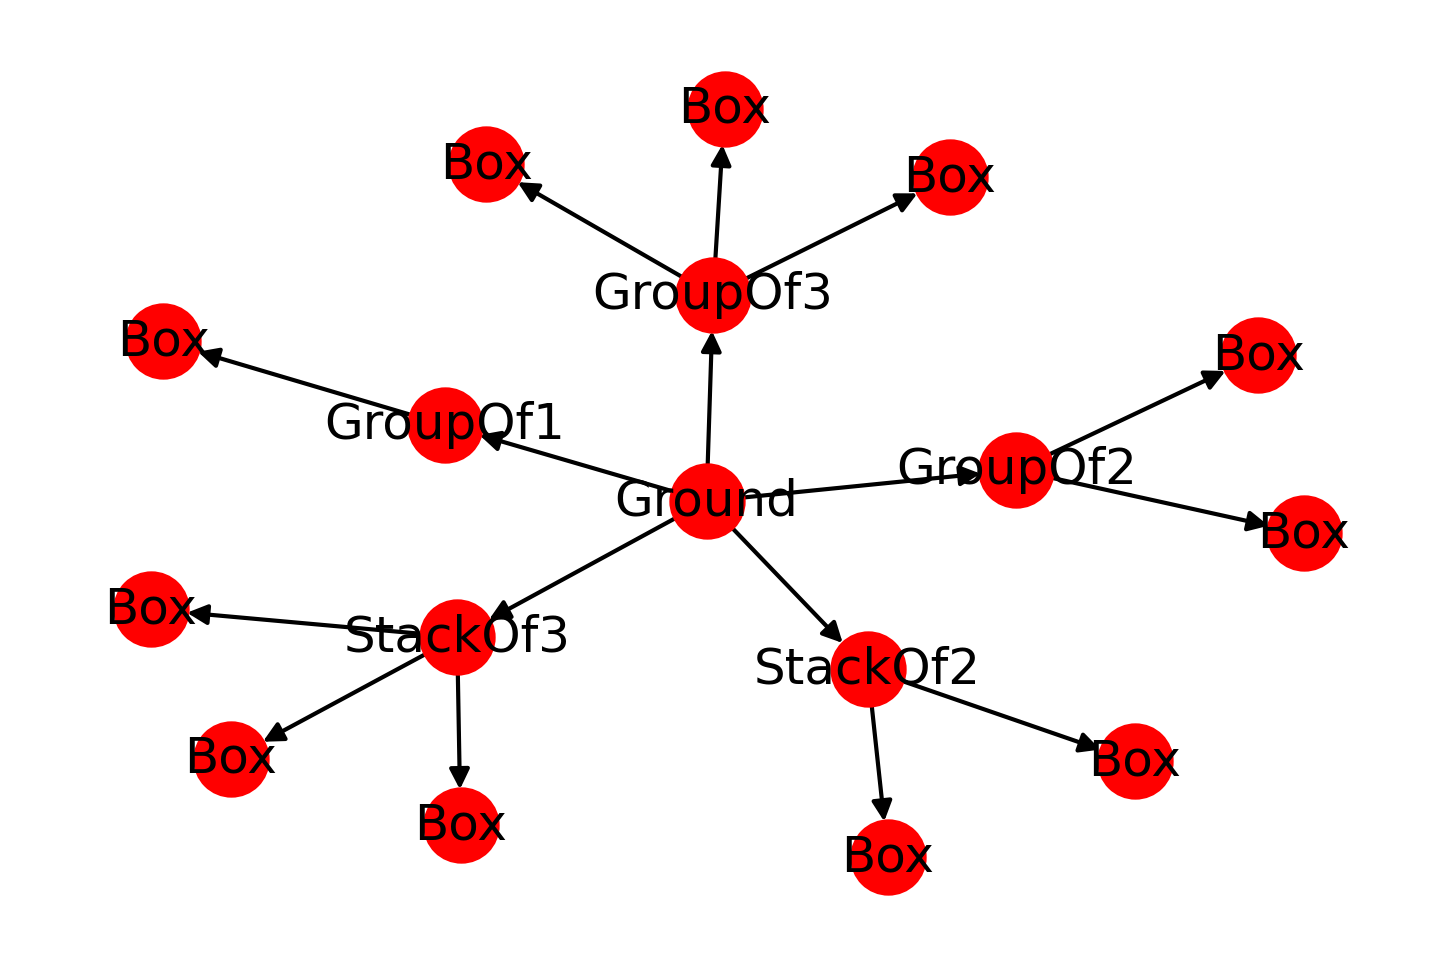

In [5]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneGrammar.make_super_scene_tree(Ground)
ordering = nx.dfs_postorder_nodes(meta_tree, source=get_tree_root(meta_tree))
index_by_node = {node: k for (k, node) in enumerate(ordering)}
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.

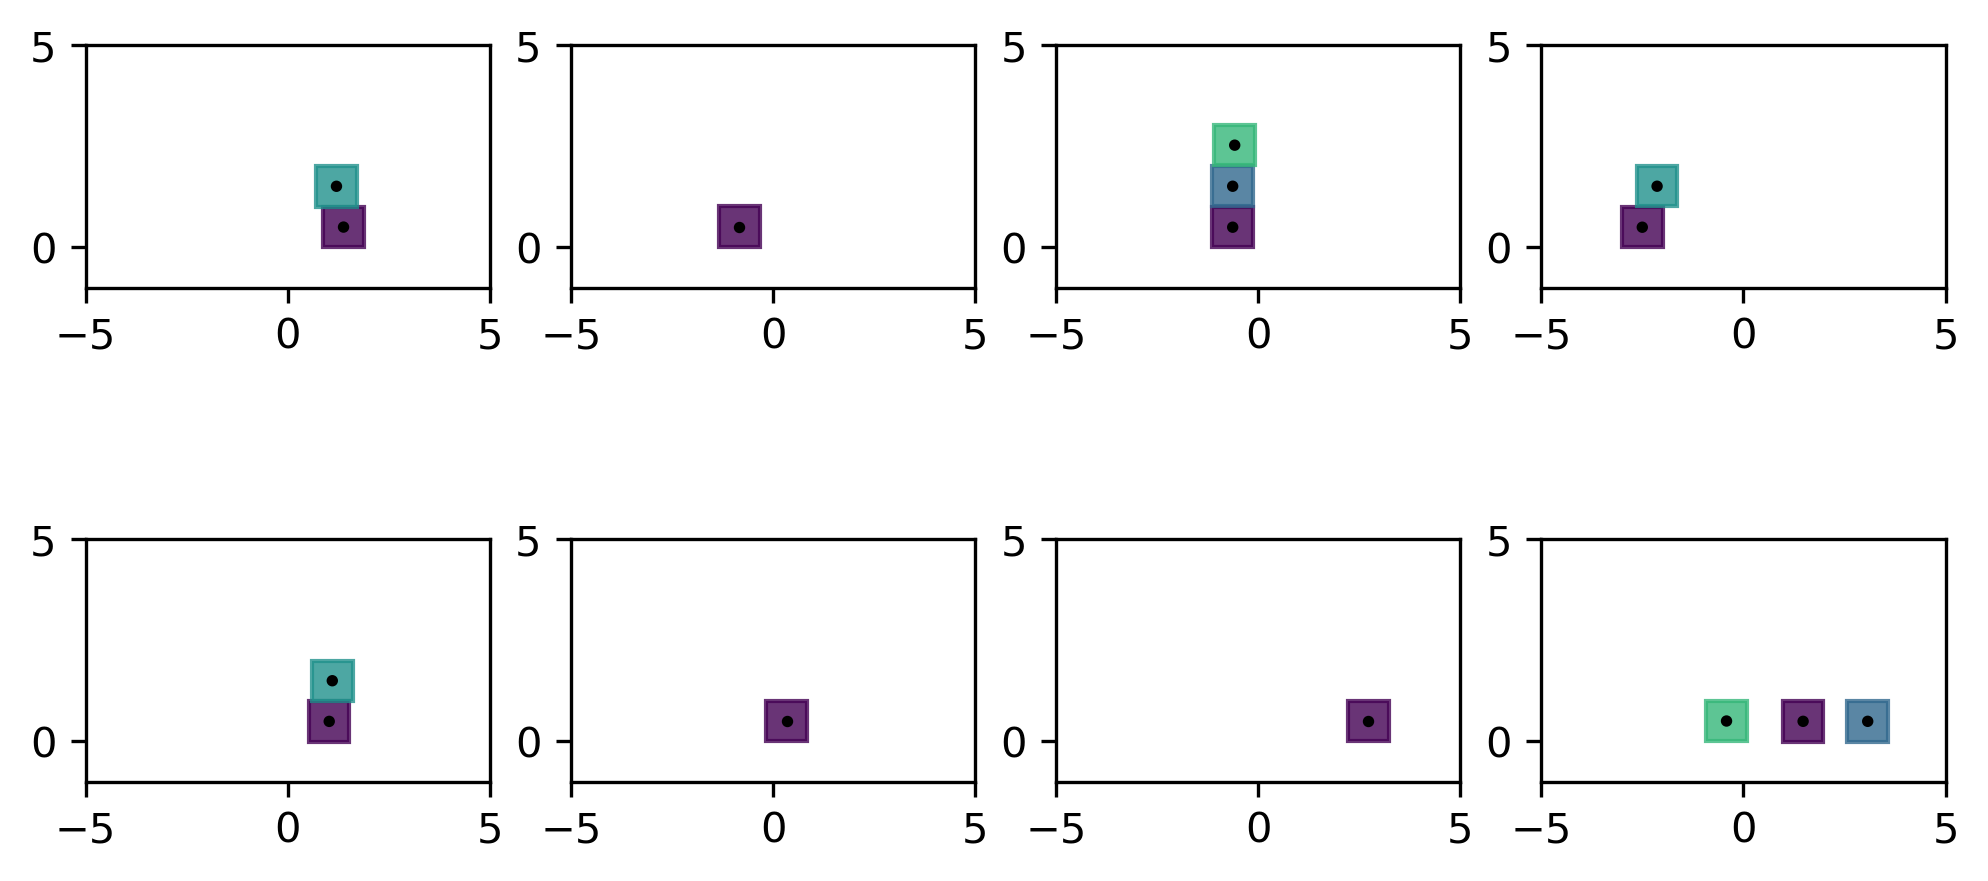

In [6]:
# Build observed trees
observed_trees = []
for tree in observed_full_trees:
    observed_tree = SceneTree()
    for node in tree:
        if isinstance(node, Box):
            observed_tree.add_node(node)
    observed_trees.append(observed_tree)

plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        k = i*N_height + j
        ax = plt.subplot(N_height, N_width, k + 1)
        draw_boxes(observed_trees[k], fig=fig, ax=ax, block=False)
        ax.axis("on")
plt.show()

## Neural grammar proposal generator on various grammars

Train an encoder to take a set of observed nodes and produce distributions over grammar parameters that are more likely to have generated those specific nodes.

##### Encoder

Exceedingly simple encoder: GRU iterations over (randomly reordered) fixed-size embeddings of each observed node, where the input is a fixed-size embedding and hidden state is the parameters of the distribution over parameters . Embeddings are generated by per-observed-node-type networks to transform variable-size node parameters into a fixed size parameter vector. 

#### Decoder and observation likelihood

A different scene grammar is a decoder: this could be the original grammar, or a different richer grammar that can generate everything the original grammar can. Given the inference grammar's parameters $z$, it induces a distribution over trees.

To train the whole system:
- Directly supervised: Given a full tree from the original grammar, the terminal nodes are encoded, and the inference grammar parameters is encouraged to be close to one that would generate the ground-truth full tree.
- Unsupervised: An observed node set is encoded. Grammars are sampled and trees forward-generated from them; each is scored against the observed node set using a supplied likelihood function. The embedding and encoder params are optimized with REINFORCE. I think that if the likelihood function ends up being an unbiased estimate of p(observed | grammar params) (perhaps by sampling trees and then computing p(observed | tree)), then this is exactly a VAE.

In [7]:
# Test out the observation likelihood.
observed_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
candidate_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
print(estimate_observation_likelihood(candidate_nodes, observed_nodes, 1./np.sqrt(2*np.pi)))

tensor([0.], grad_fn=<DivBackward0>)


In [8]:
# Make a bigger dataset of observed trees
full_trees_for_training = []
observed_nodes_for_training = []
def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            continue
        full_trees.append(scene_trees[0])
        observed_nodes.append([n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)])
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(500)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(100)

In [9]:
# Try it out with an overparam'd form of the original grammar
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = FullyParameterizedGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = SceneGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
config = GrammarEncoder.Config(rnn_type="GCN")
encoder = GrammarEncoder(inference_grammar, 512, config=config)
x = encoder(observed_nodes_for_training[0])

if 0:
    # Load encoder from saved run.
    weight_path = "saved_models/20210602/encoder_supervised_-202.3508.torch"
    encoder.load_state_dict(torch.load(weight_path))
    encoder.eval()

Text(0.5, 0.98, 'Draws from encoder/decoder before any training, on TEST')

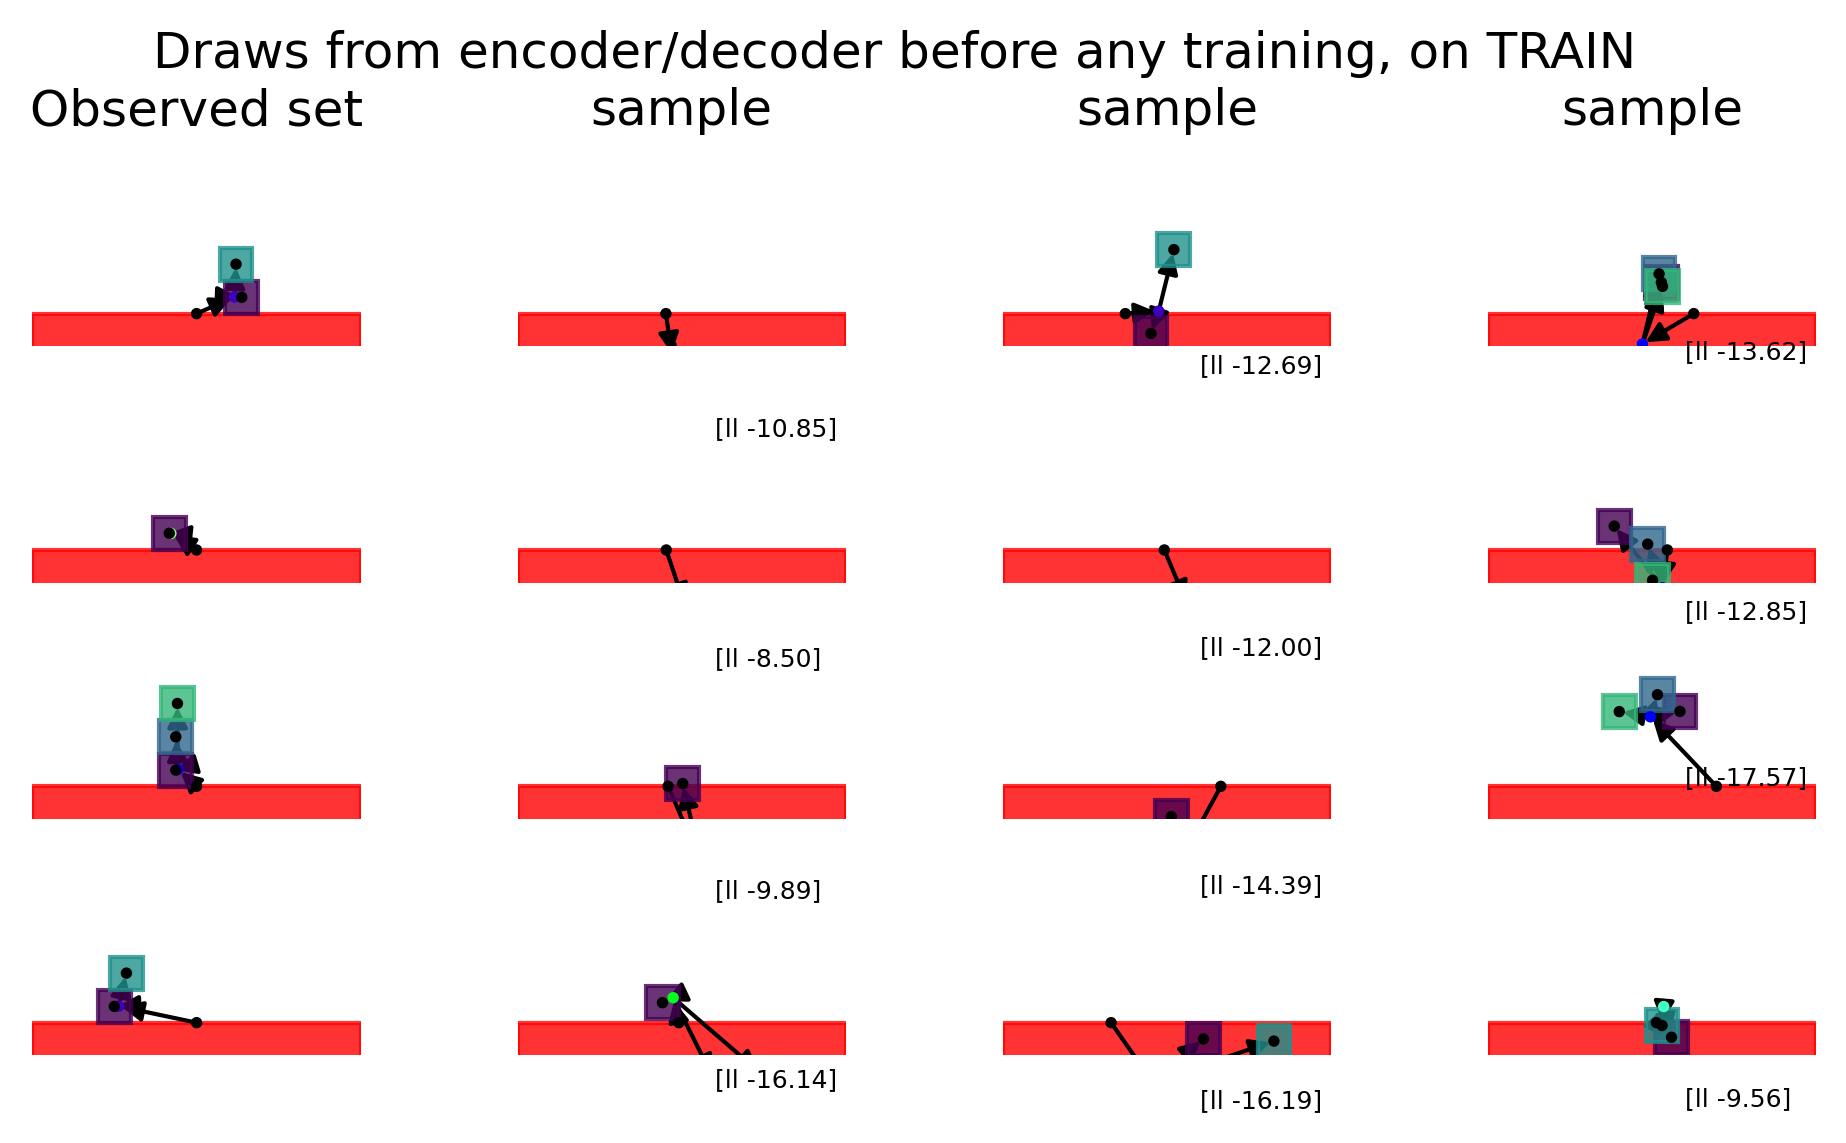

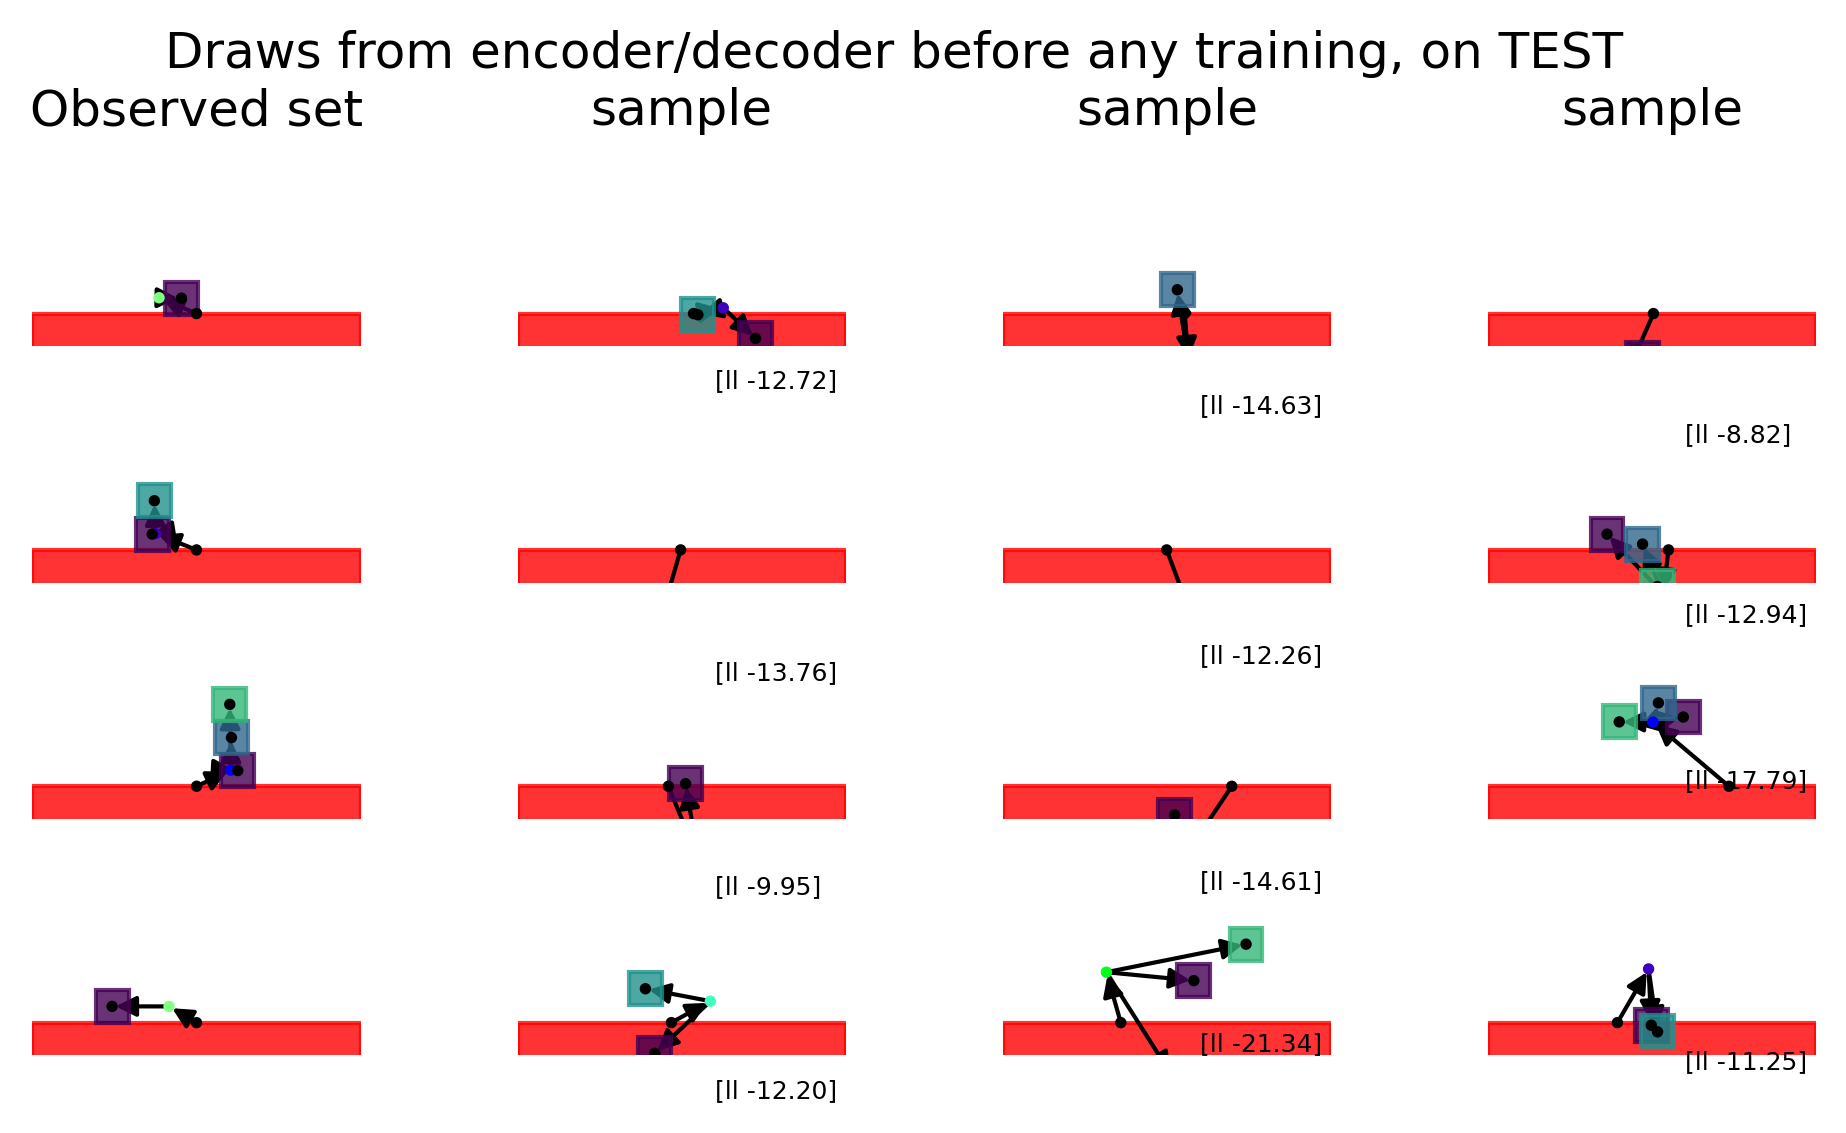

In [10]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(42)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder before any training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder before any training, on TEST")

0: 18.516357
100: -26.228172
200: -37.558594
300: -40.928658
400: -41.694103


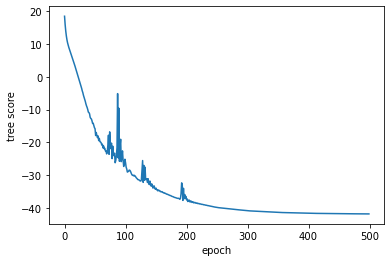

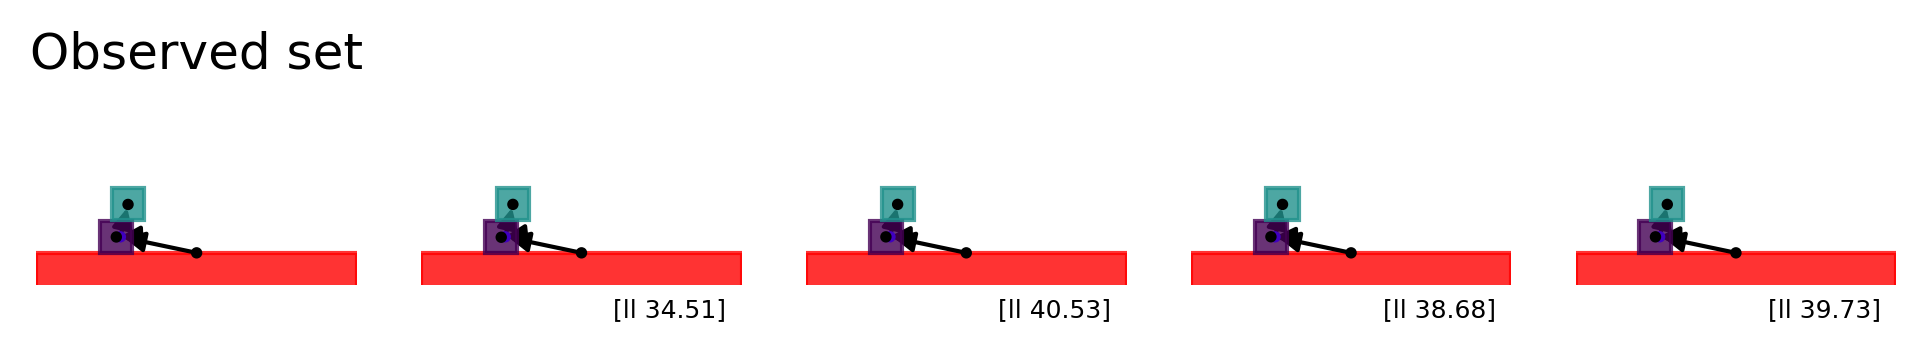

In [11]:
# Sanity-check grad descent: given a ground truth tree, can we
# recover the params of the auxiliary model that recover it?
full_tree = full_trees_for_training[3]
Nx = encoder.n_parameters
x = torch.normal(mean=torch.zeros(Nx), std=torch.ones(Nx)*0.1)
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
scores = []
for epoch in range(500):
    optimizer.zero_grad()
    score = -encoder.score_tree_with_grammar_vector(full_tree, x, detach=True)
    scores.append(score.detach().item())
    if epoch % 100 == 0:
        print("%d: %f" % (epoch, score))
    score.backward()
    optimizer.step()
    scheduler.step()
plt.plot(scores)
plt.xlabel("epoch")
plt.ylabel("tree score")
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 5
plt.subplot(1, N_width, 1)
draw_boxes(full_tree, fig=plt.gcf(), ax=plt.gca(), block=False)
plt.title("Observed set")
for k in range(N_width - 1):
    ax = plt.subplot(1, N_width, k + 2)
    plt.title("Sample %d" % k)
    sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
    draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
    plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

0:Mean objective 4.57, lr 0.001000
10:Mean objective 0.42, lr 0.001000
20:Mean objective 0.16, lr 0.000100
30:Mean objective 0.04, lr 0.000010
40:Mean objective 0.22, lr 0.000001
50:Mean objective 0.15, lr 0.000000
60:Mean objective 0.02, lr 0.000000
70:Mean objective 0.03, lr 0.000000
80:Mean objective 0.05, lr 0.000000
90:Mean objective 0.06, lr 0.000000


/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


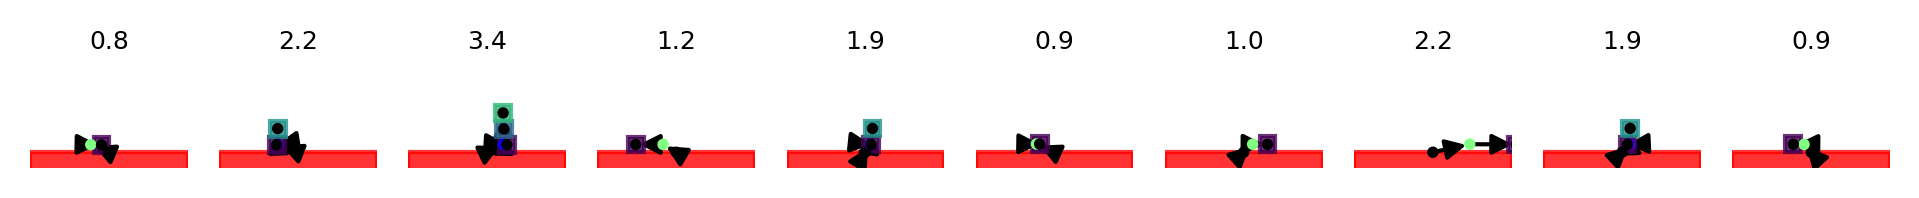

In [12]:
# Sanity check a simpler auxiliary task: can the encoder spit out x s.t. the first element of x
# is the number of objects?
# Training
N_EPOCHS = 100
N_ITERS_PER_EPOCH = 10
CLIP_VALUE = 1E3
torch.manual_seed(1234)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=10, factor=0.1)

total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        total_objective += torch.mean(torch.square(x[0] - len(observed_nodes)))
    
    mean_objective = total_objective / N_ITERS_PER_EPOCH
    total_objective_history.append(mean_objective)
    if (epoch % 10 == 0):
        print("%d:Mean objective %.2f, lr %f"
              % (epoch, mean_objective, optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (mean_objective).backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 10
plt.subplot(1, N_width, 1)
for k in range(N_width):
    ax = plt.subplot(1, N_width, k + 1)
    plt.title("Sample %d" % k)
    observed_nodes = observed_nodes_for_testing[k]
    x = encoder(observed_nodes)
    draw_boxes(full_trees_for_testing[k], fig=fig, ax=ax, block=False)
    plt.title("%0.1f" % x[0].item(), fontsize=6)


# Supervised [pre]training using full trees

This is for training the encoder to be in the neighborhood of being reasonable: given an observed tree, encode its observed nodes to get an inference grammar parameter set x, and then score the ground truth tree under that parameter set; backprob through x to increase the log-prob of the ground truth tree.

In [13]:
# Training
N_EPOCHS = 2000
N_ITERS_PER_EPOCH = 25
N_COUNTEREXAMPLES_PER_ITER = 0
CLIP_VALUE = 1E3
torch.manual_seed(1234)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=50, factor=0.5)

total_objective_history = []
score_history = []
all_gradients_history = {name: [] for name, _ in encoder.named_parameters()}
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    prior_contribution = 0.
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        
        # Calculate contribution of encoding prior (very weak, just keeps values from
        # blowing up.)
        #x_prior_ll = dist.Normal(0., 10.).log_prob(x).sum()
        #prior_contribution += x_prior_ll
        #total_objective += x_prior_ll

        full_tree = full_trees_for_training[iter_k]
        discrete_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=True,
            include_continuous=False
        )
        continuous_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=False,
            include_continuous=True
        )
        total_objective += discrete_score + continuous_score * 0.1
        
        # *And* make negative example trees unlikely under this encoding.
        for counterexample_k in range(N_COUNTEREXAMPLES_PER_ITER):
            counterexample_ind = iter_k
            while counterexample_ind == iter_k:
                counterexample_ind = np.random.randint(len(observed_nodes_for_training))
            full_tree = full_trees_for_training[counterexample_ind]
            full_tree_score = encoder.score_tree_with_grammar_vector(full_tree, x, detach=True)
            total_objective -= torch.log(1. + torch.exp(full_tree_score))
    
    mean_objective = total_objective / N_ITERS_PER_EPOCH
    prior_contribution = prior_contribution / N_ITERS_PER_EPOCH
    total_objective_history.append(mean_objective)
    score_history.append(mean_objective - prior_contribution)
    if (epoch % 1 == 0):
        print("%d:Mean objective %.2f, score %.2f, lr %f"
              % (epoch, mean_objective, mean_objective - prior_contribution, 
                 optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (-mean_objective).backward()
        # log gradients
        for name, param in encoder.named_parameters():
            if param.grad is None:
                all_gradients_history[name].append(torch.zeros(param.shape))
            else:
                all_gradients_history[name].append(deepcopy(param.grad.data))

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)

supervised_training_finish_time = time.time()

0:Mean objective -3.57, score -3.57, lr 0.001000
1:Mean objective -2.39, score -2.39, lr 0.001000
2:Mean objective -2.48, score -2.48, lr 0.001000
3:Mean objective -2.42, score -2.42, lr 0.001000
4:Mean objective -2.44, score -2.44, lr 0.001000
5:Mean objective -2.55, score -2.55, lr 0.001000
6:Mean objective -2.41, score -2.41, lr 0.001000
7:Mean objective -2.33, score -2.33, lr 0.001000
8:Mean objective -2.35, score -2.35, lr 0.001000
9:Mean objective -2.21, score -2.21, lr 0.001000
10:Mean objective -2.51, score -2.51, lr 0.001000
11:Mean objective -2.14, score -2.14, lr 0.001000
12:Mean objective -3.25, score -3.25, lr 0.001000
13:Mean objective -2.30, score -2.30, lr 0.001000
14:Mean objective -2.27, score -2.27, lr 0.001000
15:Mean objective -2.13, score -2.13, lr 0.001000
16:Mean objective -2.46, score -2.46, lr 0.001000
17:Mean objective -2.15, score -2.15, lr 0.001000
18:Mean objective -2.33, score -2.33, lr 0.001000
19:Mean objective -2.18, score -2.18, lr 0.001000
20:Mean ob

163:Mean objective -0.47, score -0.47, lr 0.001000
164:Mean objective -0.95, score -0.95, lr 0.001000
165:Mean objective -0.81, score -0.81, lr 0.001000
166:Mean objective -0.88, score -0.88, lr 0.001000
167:Mean objective -1.30, score -1.30, lr 0.001000
168:Mean objective -1.18, score -1.18, lr 0.001000
169:Mean objective -1.30, score -1.30, lr 0.001000
170:Mean objective -1.25, score -1.25, lr 0.001000
171:Mean objective -1.01, score -1.01, lr 0.001000
172:Mean objective -0.99, score -0.99, lr 0.001000
173:Mean objective -1.25, score -1.25, lr 0.001000
174:Mean objective -0.92, score -0.92, lr 0.001000
175:Mean objective -0.84, score -0.84, lr 0.001000
176:Mean objective -1.07, score -1.07, lr 0.001000
177:Mean objective -1.07, score -1.07, lr 0.001000
178:Mean objective -0.90, score -0.90, lr 0.001000
179:Mean objective -1.40, score -1.40, lr 0.001000
180:Mean objective -0.92, score -0.92, lr 0.001000
181:Mean objective -1.03, score -1.03, lr 0.001000
182:Mean objective -0.85, score

325:Mean objective 0.17, score 0.17, lr 0.000500
326:Mean objective 0.15, score 0.15, lr 0.000500
327:Mean objective 0.14, score 0.14, lr 0.000500
328:Mean objective 0.27, score 0.27, lr 0.000500
329:Mean objective -0.08, score -0.08, lr 0.000500
330:Mean objective -0.02, score -0.02, lr 0.000500
331:Mean objective -0.04, score -0.04, lr 0.000500
332:Mean objective 0.03, score 0.03, lr 0.000500
333:Mean objective 0.12, score 0.12, lr 0.000500
334:Mean objective -0.09, score -0.09, lr 0.000500
335:Mean objective 0.16, score 0.16, lr 0.000500
336:Mean objective 0.24, score 0.24, lr 0.000500
337:Mean objective 0.18, score 0.18, lr 0.000500
338:Mean objective 0.04, score 0.04, lr 0.000500
339:Mean objective -0.16, score -0.16, lr 0.000500
340:Mean objective -0.09, score -0.09, lr 0.000500
341:Mean objective 0.05, score 0.05, lr 0.000500
342:Mean objective 0.15, score 0.15, lr 0.000500
343:Mean objective -0.03, score -0.03, lr 0.000500
344:Mean objective 0.03, score 0.03, lr 0.000500
345:Me

491:Mean objective 0.33, score 0.33, lr 0.000125
492:Mean objective 0.40, score 0.40, lr 0.000125
493:Mean objective 0.29, score 0.29, lr 0.000125
494:Mean objective 0.37, score 0.37, lr 0.000125
495:Mean objective -0.01, score -0.01, lr 0.000125
496:Mean objective 0.16, score 0.16, lr 0.000125
497:Mean objective -0.03, score -0.03, lr 0.000125
498:Mean objective 0.48, score 0.48, lr 0.000125
499:Mean objective 0.30, score 0.30, lr 0.000125
500:Mean objective 0.14, score 0.14, lr 0.000125
501:Mean objective 0.25, score 0.25, lr 0.000125
502:Mean objective 0.02, score 0.02, lr 0.000125
503:Mean objective 0.60, score 0.60, lr 0.000125
504:Mean objective 0.11, score 0.11, lr 0.000125
505:Mean objective 0.17, score 0.17, lr 0.000125
506:Mean objective 0.19, score 0.19, lr 0.000125
507:Mean objective 0.69, score 0.69, lr 0.000125
508:Mean objective 0.86, score 0.86, lr 0.000125
509:Mean objective 0.41, score 0.41, lr 0.000125
510:Mean objective 0.13, score 0.13, lr 0.000125
511:Mean objecti

659:Mean objective 1.09, score 1.09, lr 0.000063
660:Mean objective 1.12, score 1.12, lr 0.000063
661:Mean objective 0.69, score 0.69, lr 0.000063
662:Mean objective 0.79, score 0.79, lr 0.000063
663:Mean objective 0.86, score 0.86, lr 0.000063
664:Mean objective 0.89, score 0.89, lr 0.000063
665:Mean objective 0.62, score 0.62, lr 0.000063
666:Mean objective 0.76, score 0.76, lr 0.000063
667:Mean objective 0.75, score 0.75, lr 0.000063
668:Mean objective 0.57, score 0.57, lr 0.000063
669:Mean objective 0.74, score 0.74, lr 0.000063
670:Mean objective 0.65, score 0.65, lr 0.000063
671:Mean objective 0.73, score 0.73, lr 0.000063
672:Mean objective 0.70, score 0.70, lr 0.000063
673:Mean objective 0.99, score 0.99, lr 0.000063
674:Mean objective 1.14, score 1.14, lr 0.000063
675:Mean objective 0.51, score 0.51, lr 0.000063
676:Mean objective 0.91, score 0.91, lr 0.000063
677:Mean objective 0.93, score 0.93, lr 0.000063
678:Mean objective 0.78, score 0.78, lr 0.000063
679:Mean objective 0

827:Mean objective 0.91, score 0.91, lr 0.000008
828:Mean objective 0.83, score 0.83, lr 0.000008
829:Mean objective 0.83, score 0.83, lr 0.000008
830:Mean objective 0.73, score 0.73, lr 0.000008
831:Mean objective 1.30, score 1.30, lr 0.000008
832:Mean objective 0.91, score 0.91, lr 0.000008
833:Mean objective 0.69, score 0.69, lr 0.000008
834:Mean objective 0.96, score 0.96, lr 0.000008
835:Mean objective 0.96, score 0.96, lr 0.000008
836:Mean objective 1.01, score 1.01, lr 0.000008
837:Mean objective 0.82, score 0.82, lr 0.000008
838:Mean objective 0.70, score 0.70, lr 0.000008
839:Mean objective 0.61, score 0.61, lr 0.000008
840:Mean objective 0.94, score 0.94, lr 0.000008
841:Mean objective 0.65, score 0.65, lr 0.000008
842:Mean objective 0.72, score 0.72, lr 0.000008
843:Mean objective 1.54, score 1.54, lr 0.000008
844:Mean objective 0.99, score 0.99, lr 0.000008
845:Mean objective 0.68, score 0.68, lr 0.000008
846:Mean objective 0.79, score 0.79, lr 0.000008
847:Mean objective 1

995:Mean objective 1.12, score 1.12, lr 0.000002
996:Mean objective 1.28, score 1.28, lr 0.000002
997:Mean objective 1.22, score 1.22, lr 0.000002
998:Mean objective 0.72, score 0.72, lr 0.000002
999:Mean objective 0.95, score 0.95, lr 0.000002
1000:Mean objective 0.87, score 0.87, lr 0.000002
1001:Mean objective 1.23, score 1.23, lr 0.000002
1002:Mean objective 1.08, score 1.08, lr 0.000002
1003:Mean objective 1.13, score 1.13, lr 0.000002
1004:Mean objective 0.98, score 0.98, lr 0.000002
1005:Mean objective 1.36, score 1.36, lr 0.000002
1006:Mean objective 0.97, score 0.97, lr 0.000002
1007:Mean objective 1.14, score 1.14, lr 0.000002
1008:Mean objective 1.19, score 1.19, lr 0.000002
1009:Mean objective 1.13, score 1.13, lr 0.000001
1010:Mean objective 1.09, score 1.09, lr 0.000001
1011:Mean objective 0.98, score 0.98, lr 0.000001
1012:Mean objective 0.68, score 0.68, lr 0.000001
1013:Mean objective 1.37, score 1.37, lr 0.000001
1014:Mean objective 0.73, score 0.73, lr 0.000001
1015:

1159:Mean objective 1.20, score 1.20, lr 0.000000
1160:Mean objective 0.93, score 0.93, lr 0.000000
1161:Mean objective 0.99, score 0.99, lr 0.000000
1162:Mean objective 0.75, score 0.75, lr 0.000000
1163:Mean objective 0.96, score 0.96, lr 0.000000
1164:Mean objective 0.87, score 0.87, lr 0.000000
1165:Mean objective 1.01, score 1.01, lr 0.000000
1166:Mean objective 0.90, score 0.90, lr 0.000000
1167:Mean objective 1.44, score 1.44, lr 0.000000
1168:Mean objective 0.82, score 0.82, lr 0.000000
1169:Mean objective 1.08, score 1.08, lr 0.000000
1170:Mean objective 1.01, score 1.01, lr 0.000000
1171:Mean objective 0.79, score 0.79, lr 0.000000
1172:Mean objective 0.97, score 0.97, lr 0.000000
1173:Mean objective 0.84, score 0.84, lr 0.000000
1174:Mean objective 1.18, score 1.18, lr 0.000000
1175:Mean objective 0.94, score 0.94, lr 0.000000
1176:Mean objective 1.52, score 1.52, lr 0.000000
1177:Mean objective 1.05, score 1.05, lr 0.000000
1178:Mean objective 0.90, score 0.90, lr 0.000000


1323:Mean objective 0.82, score 0.82, lr 0.000000
1324:Mean objective 0.79, score 0.79, lr 0.000000
1325:Mean objective 1.13, score 1.13, lr 0.000000
1326:Mean objective 1.06, score 1.06, lr 0.000000
1327:Mean objective 1.40, score 1.40, lr 0.000000
1328:Mean objective 1.42, score 1.42, lr 0.000000
1329:Mean objective 1.26, score 1.26, lr 0.000000
1330:Mean objective 0.56, score 0.56, lr 0.000000
1331:Mean objective 1.07, score 1.07, lr 0.000000
1332:Mean objective 1.02, score 1.02, lr 0.000000
1333:Mean objective 1.02, score 1.02, lr 0.000000
1334:Mean objective 1.05, score 1.05, lr 0.000000
1335:Mean objective 0.97, score 0.97, lr 0.000000
1336:Mean objective 1.07, score 1.07, lr 0.000000
1337:Mean objective 1.15, score 1.15, lr 0.000000
1338:Mean objective 1.29, score 1.29, lr 0.000000
1339:Mean objective 1.11, score 1.11, lr 0.000000
1340:Mean objective 0.74, score 0.74, lr 0.000000
1341:Mean objective 1.05, score 1.05, lr 0.000000
1342:Mean objective 0.85, score 0.85, lr 0.000000


1487:Mean objective 0.86, score 0.86, lr 0.000000
1488:Mean objective 1.10, score 1.10, lr 0.000000
1489:Mean objective 1.06, score 1.06, lr 0.000000
1490:Mean objective 0.97, score 0.97, lr 0.000000
1491:Mean objective 1.04, score 1.04, lr 0.000000
1492:Mean objective 0.81, score 0.81, lr 0.000000
1493:Mean objective 0.85, score 0.85, lr 0.000000
1494:Mean objective 0.82, score 0.82, lr 0.000000
1495:Mean objective 1.06, score 1.06, lr 0.000000
1496:Mean objective 1.09, score 1.09, lr 0.000000
1497:Mean objective 0.88, score 0.88, lr 0.000000
1498:Mean objective 1.04, score 1.04, lr 0.000000
1499:Mean objective 1.02, score 1.02, lr 0.000000
1500:Mean objective 1.14, score 1.14, lr 0.000000
1501:Mean objective 0.84, score 0.84, lr 0.000000
1502:Mean objective 0.83, score 0.83, lr 0.000000
1503:Mean objective 1.15, score 1.15, lr 0.000000
1504:Mean objective 0.74, score 0.74, lr 0.000000
1505:Mean objective 1.04, score 1.04, lr 0.000000
1506:Mean objective 0.98, score 0.98, lr 0.000000


1651:Mean objective 0.90, score 0.90, lr 0.000000
1652:Mean objective 0.97, score 0.97, lr 0.000000
1653:Mean objective 1.17, score 1.17, lr 0.000000
1654:Mean objective 0.96, score 0.96, lr 0.000000
1655:Mean objective 1.09, score 1.09, lr 0.000000
1656:Mean objective 1.18, score 1.18, lr 0.000000
1657:Mean objective 1.19, score 1.19, lr 0.000000
1658:Mean objective 0.93, score 0.93, lr 0.000000
1659:Mean objective 0.76, score 0.76, lr 0.000000
1660:Mean objective 1.11, score 1.11, lr 0.000000
1661:Mean objective 1.33, score 1.33, lr 0.000000
1662:Mean objective 0.96, score 0.96, lr 0.000000
1663:Mean objective 1.26, score 1.26, lr 0.000000
1664:Mean objective 0.88, score 0.88, lr 0.000000
1665:Mean objective 0.92, score 0.92, lr 0.000000
1666:Mean objective 0.91, score 0.91, lr 0.000000
1667:Mean objective 1.30, score 1.30, lr 0.000000
1668:Mean objective 0.89, score 0.89, lr 0.000000
1669:Mean objective 1.22, score 1.22, lr 0.000000
1670:Mean objective 0.90, score 0.90, lr 0.000000


1815:Mean objective 1.26, score 1.26, lr 0.000000
1816:Mean objective 1.02, score 1.02, lr 0.000000
1817:Mean objective 1.07, score 1.07, lr 0.000000
1818:Mean objective 1.01, score 1.01, lr 0.000000
1819:Mean objective 1.12, score 1.12, lr 0.000000
1820:Mean objective 0.79, score 0.79, lr 0.000000
1821:Mean objective 1.40, score 1.40, lr 0.000000
1822:Mean objective 1.36, score 1.36, lr 0.000000
1823:Mean objective 1.02, score 1.02, lr 0.000000
1824:Mean objective 0.90, score 0.90, lr 0.000000
1825:Mean objective 0.83, score 0.83, lr 0.000000
1826:Mean objective 1.23, score 1.23, lr 0.000000
1827:Mean objective 1.42, score 1.42, lr 0.000000
1828:Mean objective 1.02, score 1.02, lr 0.000000
1829:Mean objective 1.21, score 1.21, lr 0.000000
1830:Mean objective 1.19, score 1.19, lr 0.000000
1831:Mean objective 0.65, score 0.65, lr 0.000000
1832:Mean objective 0.91, score 0.91, lr 0.000000
1833:Mean objective 1.20, score 1.20, lr 0.000000
1834:Mean objective 0.80, score 0.80, lr 0.000000


1979:Mean objective 1.01, score 1.01, lr 0.000000
1980:Mean objective 1.16, score 1.16, lr 0.000000
1981:Mean objective 1.14, score 1.14, lr 0.000000
1982:Mean objective 0.95, score 0.95, lr 0.000000
1983:Mean objective 1.17, score 1.17, lr 0.000000
1984:Mean objective 1.08, score 1.08, lr 0.000000
1985:Mean objective 0.64, score 0.64, lr 0.000000
1986:Mean objective 1.02, score 1.02, lr 0.000000
1987:Mean objective 0.84, score 0.84, lr 0.000000
1988:Mean objective 0.70, score 0.70, lr 0.000000
1989:Mean objective 0.87, score 0.87, lr 0.000000
1990:Mean objective 0.85, score 0.85, lr 0.000000
1991:Mean objective 0.96, score 0.96, lr 0.000000
1992:Mean objective 0.85, score 0.85, lr 0.000000
1993:Mean objective 1.37, score 1.37, lr 0.000000
1994:Mean objective 0.86, score 0.86, lr 0.000000
1995:Mean objective 0.98, score 0.98, lr 0.000000
1996:Mean objective 1.24, score 1.24, lr 0.000000
1997:Mean objective 0.69, score 0.69, lr 0.000000
1998:Mean objective 1.01, score 1.01, lr 0.000000


Text(0.5, 1.0, 'Total objective')

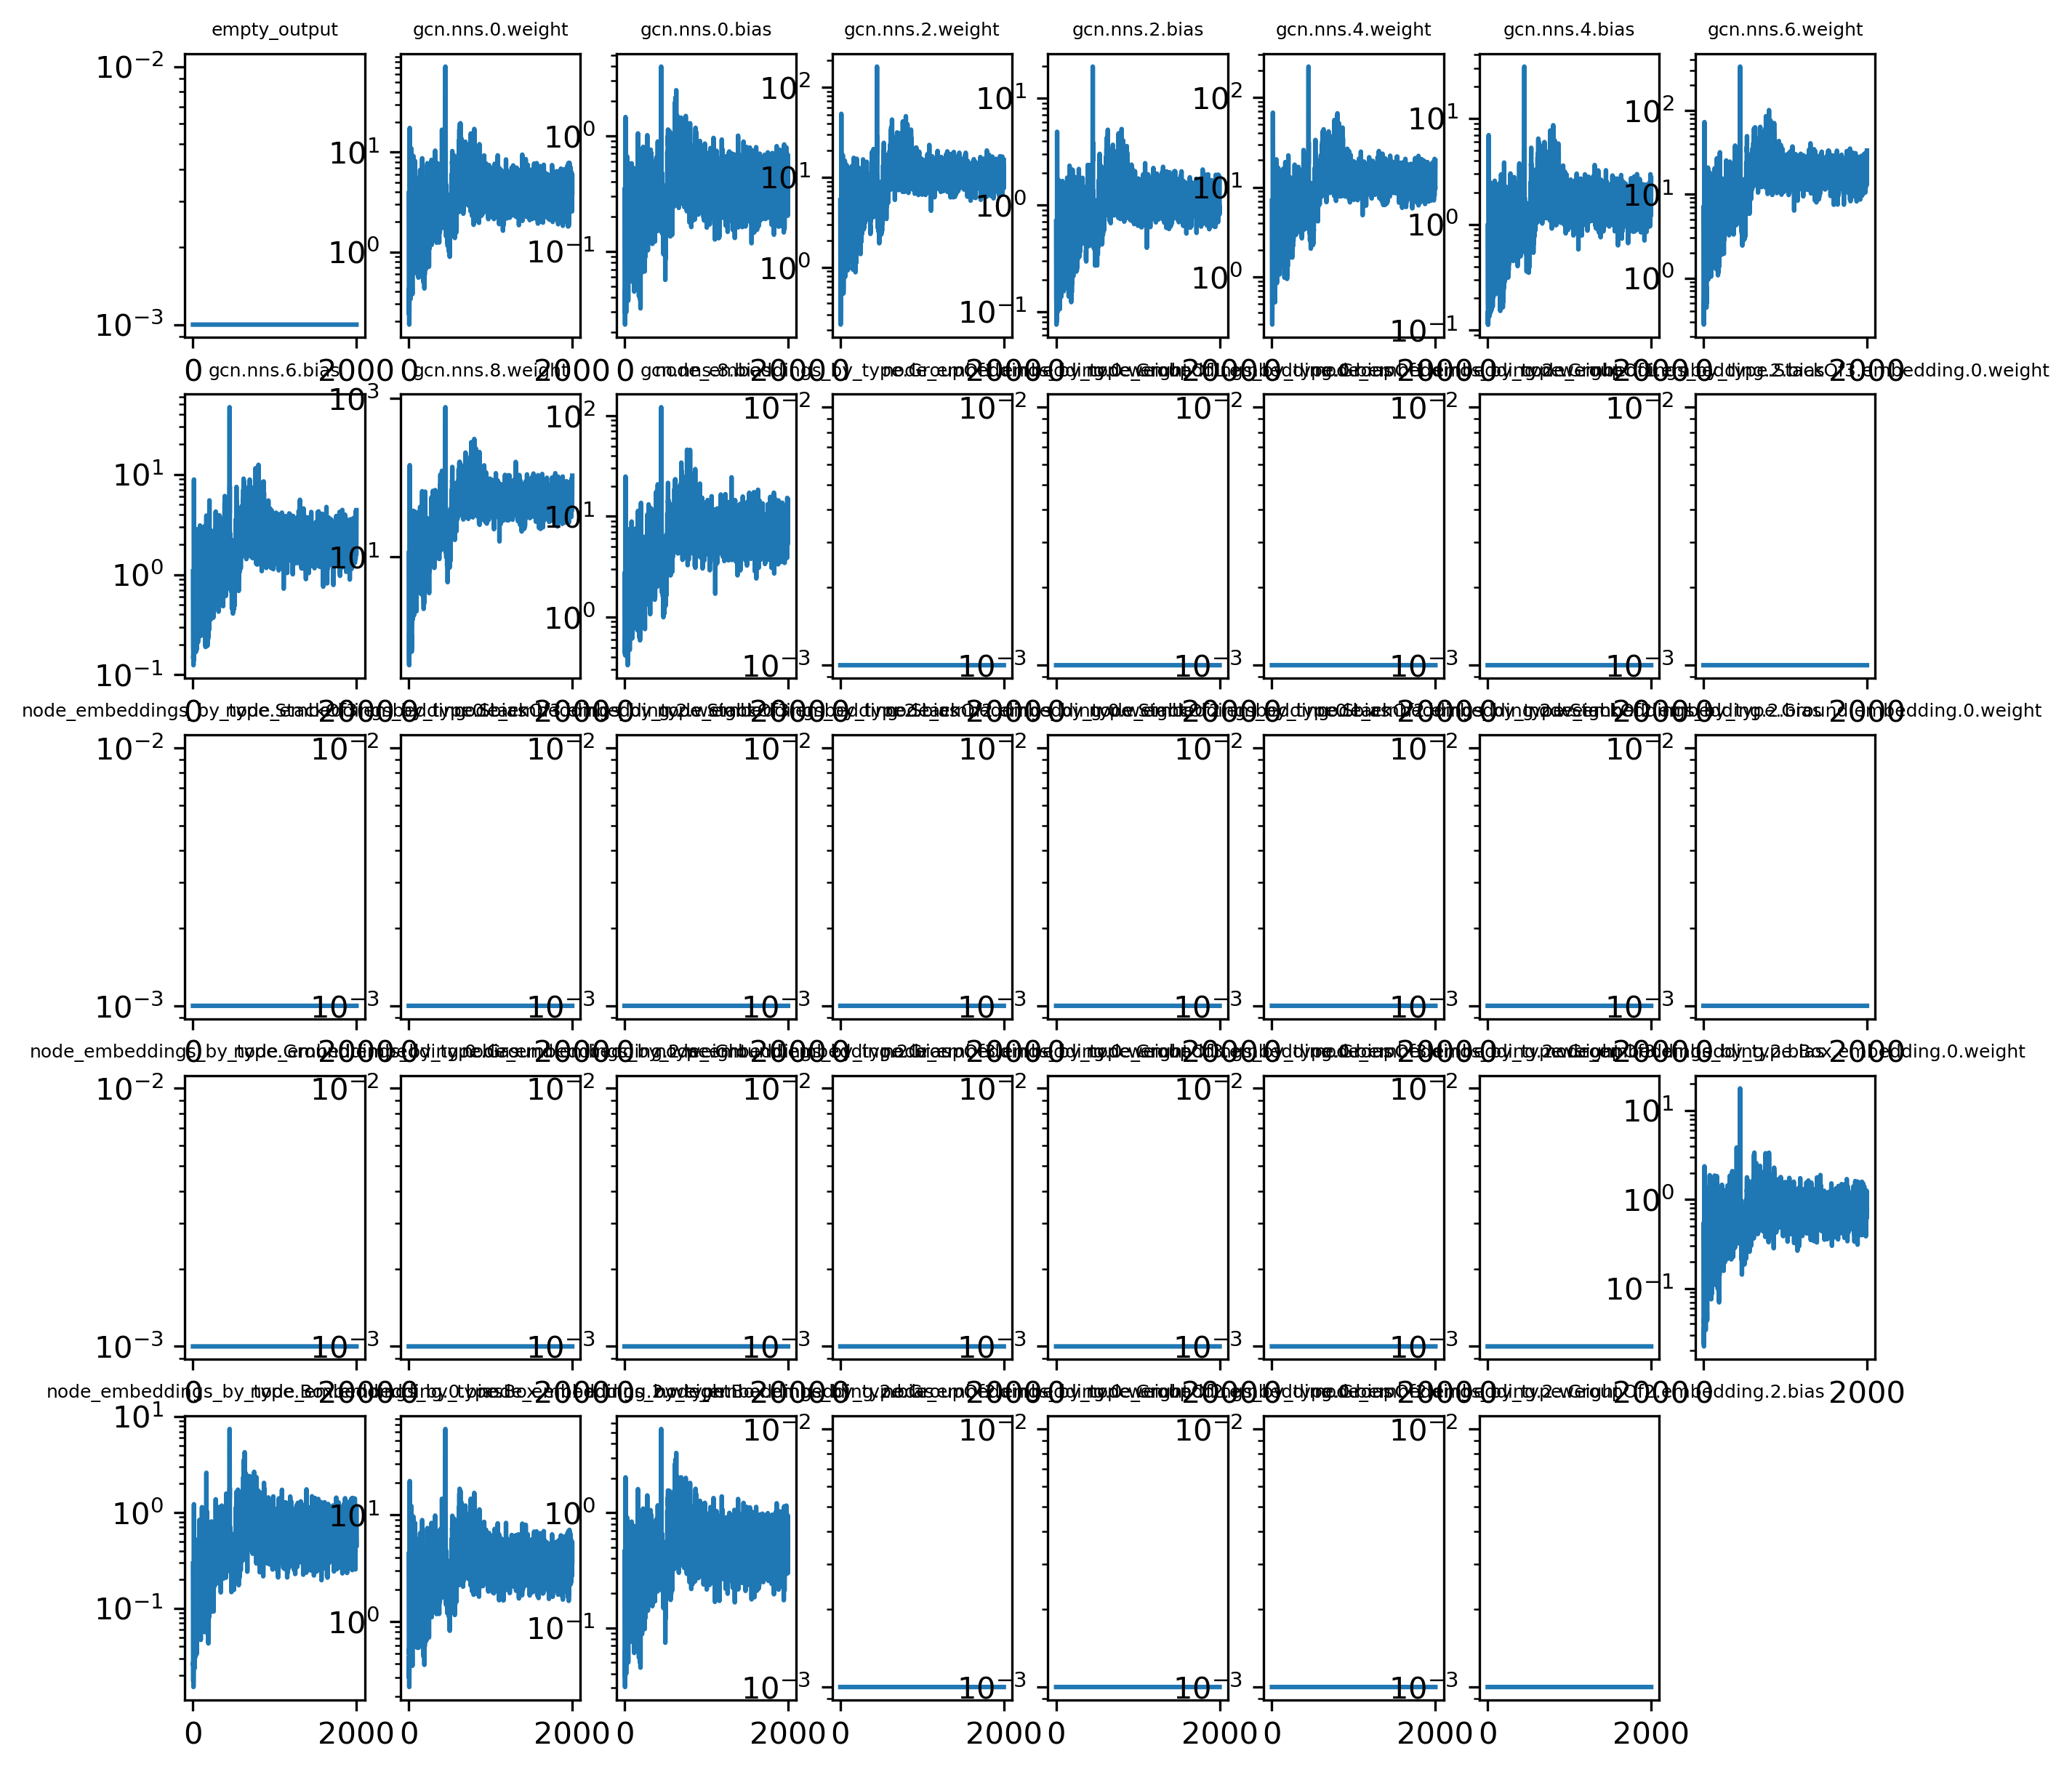

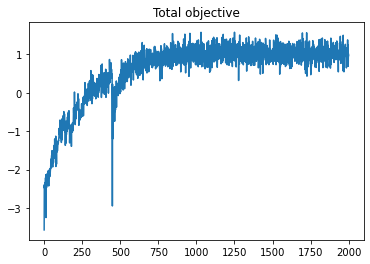

In [16]:
# Draw gradient norm history per param
plt.figure(dpi=300).set_size_inches(10, 10)
n_params = len(all_gradients_history.keys())
for k, (name, history) in enumerate(all_gradients_history.items()):
    ax = plt.subplot(5, n_params // 5 + 1, k+1)
    history = torch.stack(history)
    history = np.linalg.norm(history.reshape(history.shape[0], -1).numpy(), axis=1) + 1E-3
    x = range(history.shape[0])
    ax.plot(x, history)
    plt.yscale("log")
    #ax.fill_between(x, (means-std), (means+std), color='b', alpha=.1)
    plt.title(name, fontsize=6)

plt.figure()
plt.plot(total_objective_history)
plt.title("Total objective")

Entering example  0
Entering example  1
Entering example  2
Entering example  3
Entering example  0
Entering example  1
Entering example  2
Entering example  3


Text(0.5, 0.98, 'Draws from encoder/decoder after supervised training, on TEST')

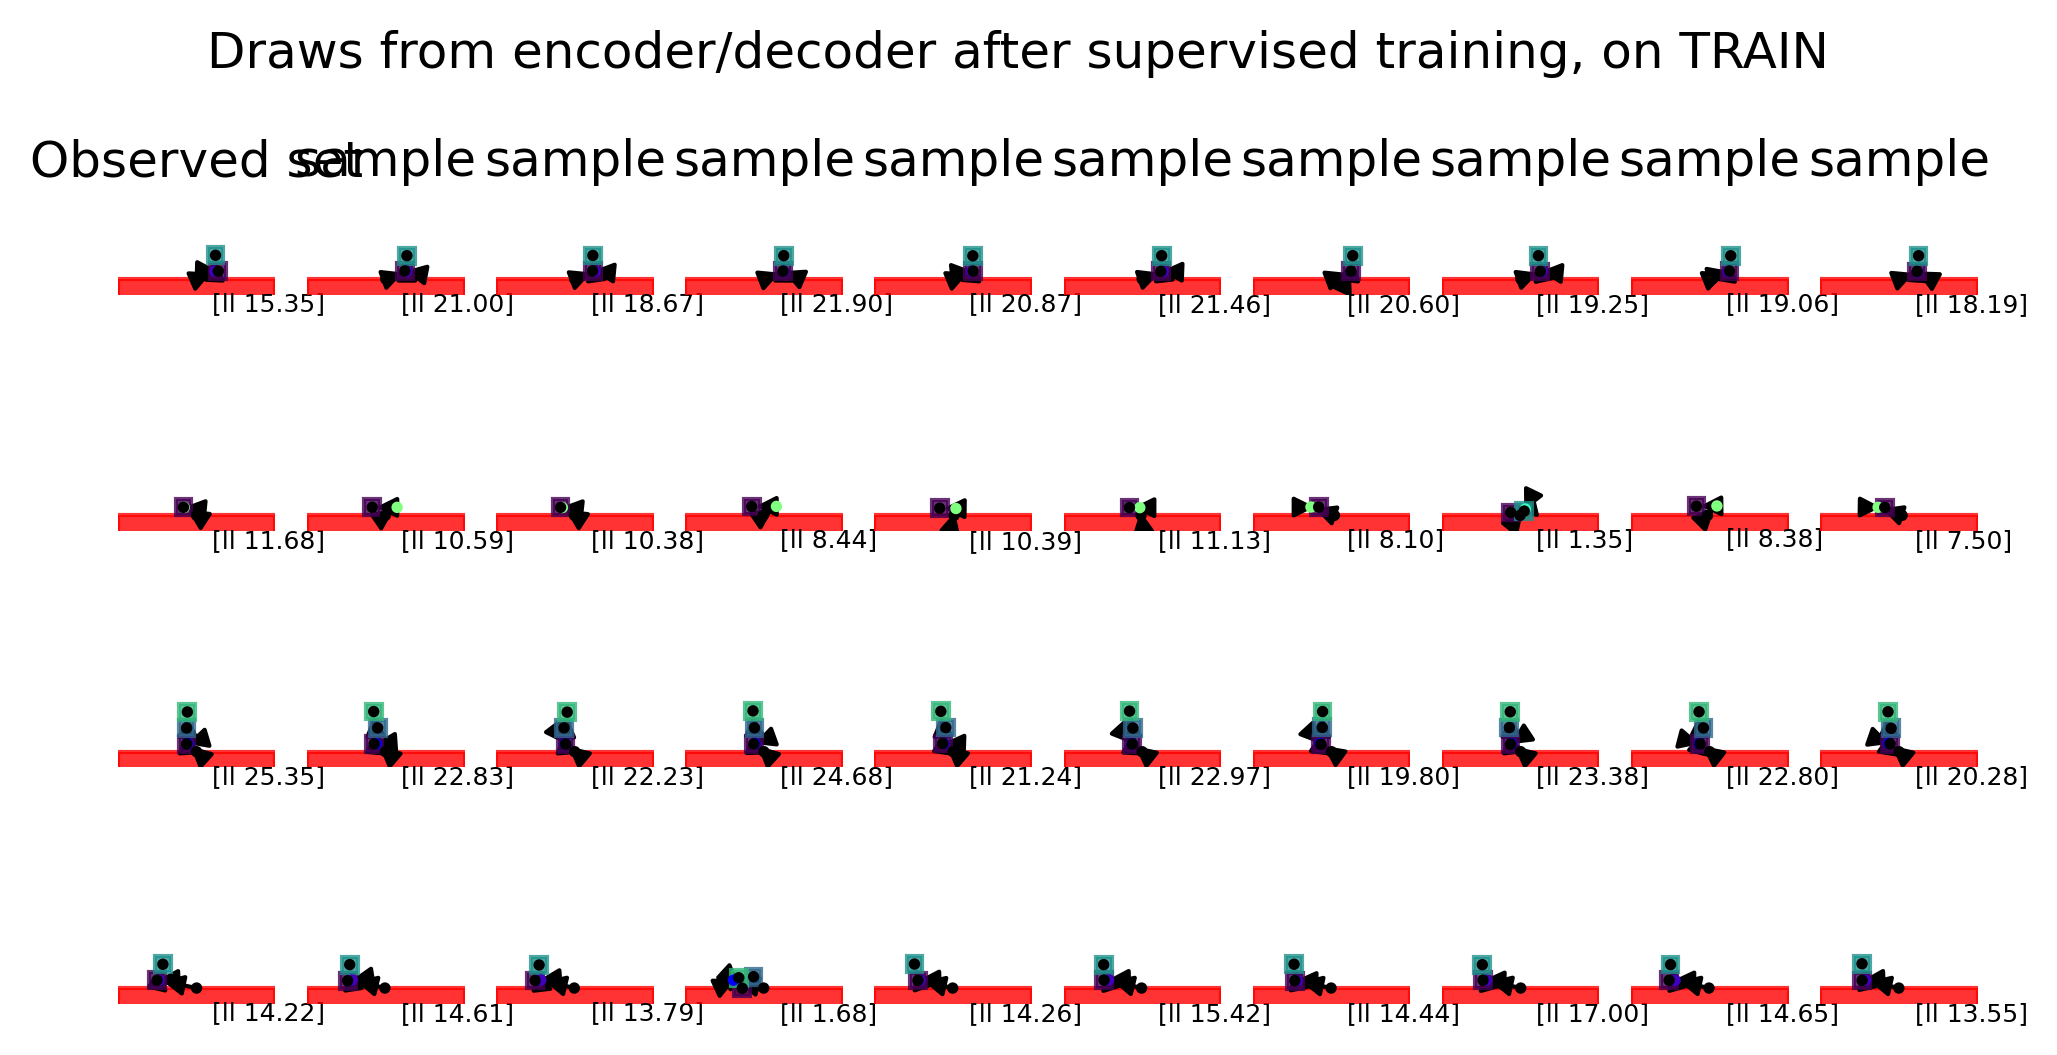

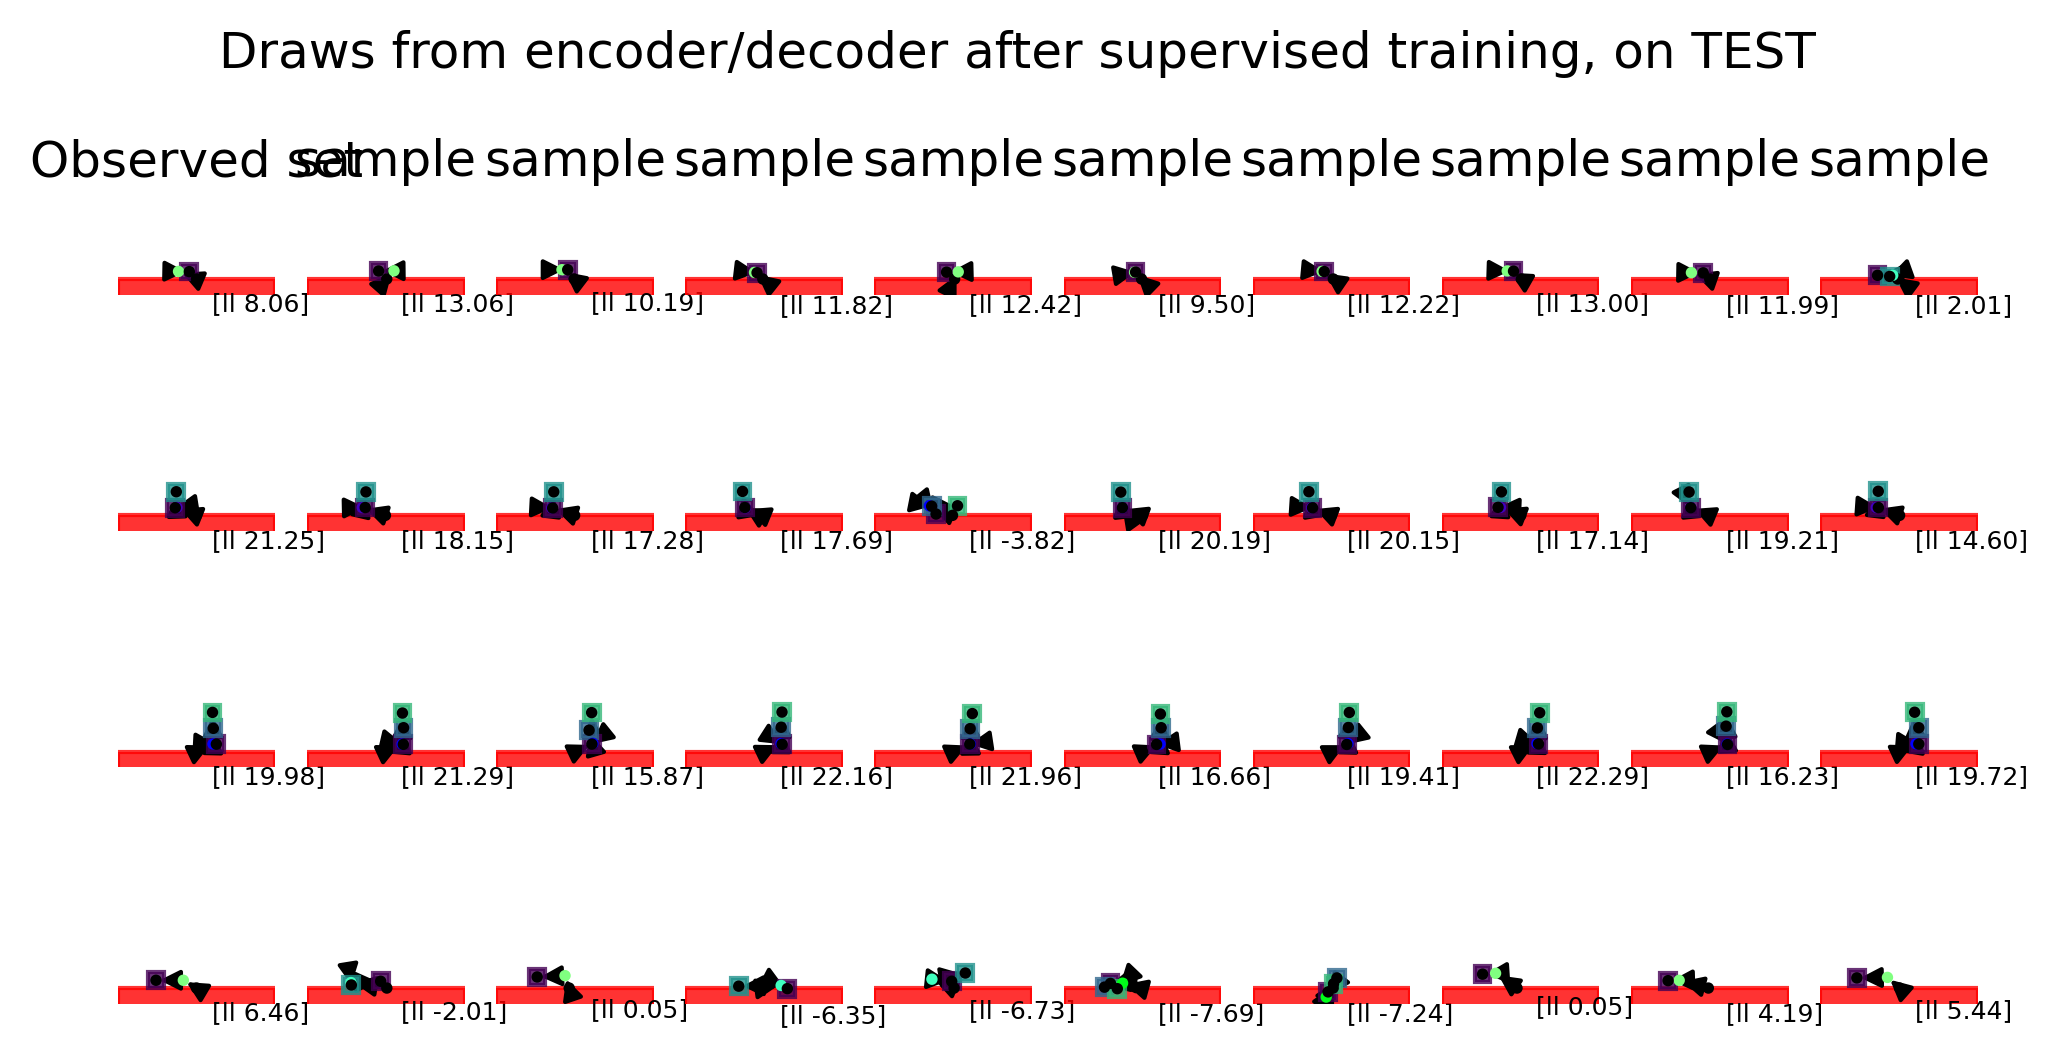

In [14]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 10
    N_height = 4
    torch.random.manual_seed(41)
    
    for i in range(N_height):
        print("Entering example ", i)
        plt.subplot(N_height, N_width, i*N_width + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        
        # Score the test tree under its encoded vector
        density = encoder.score_tree_with_grammar_vector(full_trees[i], x, include_continuous=True)
        plt.text(x=1., y=-2., s="[ll %0.2f]" % density, fontsize=6)
        
        for j in range(1, N_width):
            k = i*N_width + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, _, _ = encoder.sample_tree_from_grammar_vector(x)
            proposal_density = encoder.score_tree_with_grammar_vector(sampled_tree, x, include_continuous=True)
            #box_k = 0
            #for node in sampled_tree.nodes:
            #    if isinstance(node, Box):
            #        node.xy = torch.tensor([0., box_k])
            #        box_k += 1
            #    else:
            #        node.xy = torch.zeros(2)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after supervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after supervised training, on TEST")

In [15]:
# Save output
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime())
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_supervised_%0.04f.torch" % (
    total_objective_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)

Saved model to saved_models/20210603/encoder_supervised_0.9641.torch


# Autoencoder Loss Training via Reinforce

Encoding is deterministic, but decoding involves drawing samples of trees from that distribution. I'll notate that whole parameterized enc-decode sampling as drawing $t \sim q_\theta(t^*)$.

To first see if things work, I'd like to directly optimize a loss function $f$ that roughly enforces observed node similarity while being close to the proposal density prior and original grammar prior  $max_\theta E_{t \sim q_\theta(t^*)}\Big[ f(t, t^*) \Big] + log p(\theta)$, for $f(t, t^*) = L(t, t^*) + p(t)$.

So we've unfortunately to use REINFORCE since the decoder is a complex sampling procedure, so our gradient estimate is $E_{t \sim q_\theta(t^*)}\Big[ (f(t, t^*) \nabla_\theta \log q_\theta(t^*) \Big] + log p(\theta) $. (Since I'm operating in pytorch, I'll build a surrogate objective that has that gradient.)


In [ ]:
# Training
N_EPOCHS = 450
N_ITERS_PER_EPOCH = 10
N_SAMPLES_PER_ENCODING = 5
MIN_LL_SATURATION = -10000

torch.manual_seed(43)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,300], gamma=0.33)
mean_sampled_f_history = []
mean_sampled_score_history = []
total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    total_sampled_f = 0.
    total_sampled_score = 0.
    total_num_samples = 0
    optimizer.zero_grad()

    if len(mean_sampled_f_history) == 0:
        decaying_avg_baseline = 0.
    elif len(mean_sampled_f_history) < 10:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history))
    else:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history[-10:]))

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        # Calculate contribution of encoding prior (very weak, just keeps values from
        # blowing up.)
        #x_prior_ll = dist.Normal(0., 10.).log_prob(x).sum()
        #total_objective += x_prior_ll * N_SAMPLES_PER_ENCODING
        for sample_k in range(N_SAMPLES_PER_ENCODING):
            sampled_tree, proposal_density_ll, nonreparam_density_ll = encoder.sample_tree_from_grammar_vector(x)
            candidate_nodes = [n for n in sampled_tree.nodes if isinstance(n, TerminalNode)]
            
            # Calculate observation matching score.
            est_ll = (estimate_observation_likelihood(candidate_nodes, observed_nodes, 0.1, detach_second=True) +
                      estimate_observation_likelihood(observed_nodes, candidate_nodes, 0.1, detach_first=True)).sum()
            est_ll = torch.clip(est_ll, min=MIN_LL_SATURATION)
            
            # Calculate grammar prior score.
            grammar_ll = grammar.score(sampled_tree)
            
            # Total value under expectation for evaluation policy gradient.
            total_f = est_ll# + grammar_ll
            
            # Diagnostics
            total_sampled_score += est_ll
            total_sampled_f += total_f
            
            # Surrogate objective for REINFORCE
            total_objective += (total_f.detach() - decaying_avg_baseline) * nonreparam_density_ll + total_f
            total_num_samples += 1

    mean_objective = total_objective / total_num_samples
    mean_sampled_f = total_sampled_f / total_num_samples
    mean_sampled_score = total_sampled_score / total_num_samples
    mean_sampled_f_history.append(mean_sampled_f)
    total_objective_history.append(mean_objective)

    print("%d: Mean sampled loss %.2f, f %.2f, Mean objective %.2f"
          % (epoch, mean_sampled_score, mean_sampled_f, mean_objective))
    
    if torch.isfinite(mean_objective):
        # Parameter values get gradients calculated but not used;
        # need to retain them to keep pytorch from complaining.
        (-mean_objective).backward(retain_graph=True)
        optimizer.step()
        scheduler.step()

unsupervised_training_finish_time = time.time()

# Test gradient
#from torchviz import make_dot
#make_dot(mean_sampled_f, params=dict(encoder.named_parameters()))

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(np.array(mean_sampled_f_history) - max(mean_sampled_f_history).item())
plt.title("Mean sampled f, relative to max")      
plt.yscale('symlog')
plt.subplot(1, 2, 2)
plt.plot(np.array(mean_sampled_f_history))
plt.title("Total objective")

In [ ]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TEST")


In [ ]:
# Save weights
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime(supervised_training_finish_time))
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_unsupervised_%0.04f.torch" % (
    mean_sampled_f_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)